# Metadata

```yaml
course:   DS 5001 
topic:    LDA (Topic Modelling)
author:   Andrew Chaphiv (acgq2@virginia.edu)
date:    SPR2023
```


# Setting Hyperparameters

In [15]:
ngram_range = [1,3]
n_terms = 4000
n_topics = 10
max_iter = 5
n_top_terms = 7
OHCO = ['abstract_num', 'sent_num']

# Importing Modules and Data Files

In [16]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
import plotly_express as px

In [17]:
CORPUS = pd.read_csv(f'abstracts-CORPUS.csv')
LIB = pd.read_csv(f'abstracts-LIB.csv', index_col = 0)


In [18]:
# Writing generating the topic models by writing a function 
def generate_topic_model(BAG = ['abstract_num', 'sent_num']): 
    DOCS = CORPUS[CORPUS.pos.str.match(r'^NNS?$')]\
    .groupby(['abstract_num','sent_num']).term_str\
    .apply(lambda x: ' '.join(map(str, x)))\
    .to_frame()\
    .rename(columns={'term_str':'doc_str'})
    
    count_engine = CountVectorizer(max_features=n_terms, ngram_range=ngram_range, stop_words='english')
    count_model = count_engine.fit_transform(DOCS.doc_str)
    TERMS = count_engine.get_feature_names()
    VOCAB = pd.DataFrame(index=TERMS)
    VOCAB.index.name = 'term_str'
    DTM = pd.DataFrame(count_model.toarray(), index=DOCS.index, columns=TERMS)
    VOCAB['doc_count'] = DTM.astype('bool').astype('int').sum()
    DOCS['term_count'] = DTM.sum(1)
    lda_engine = LDA(n_components=n_topics, max_iter=max_iter, learning_offset=50., random_state=0)
    TNAMES = [f"T{str(x).zfill(len(str(n_topics)))}" for x in range(n_topics)]
    lda_model = lda_engine.fit_transform(count_model)
    THETA = pd.DataFrame(lda_model, index=DOCS.index)
    THETA.columns.name = 'topic_id'
    THETA.columns = TNAMES
    PHI = pd.DataFrame(lda_engine.components_, columns=TERMS, index=TNAMES)
    PHI.index.name = 'topic_id'
    PHI.columns.name  = 'term_str'
    TOPICS = PHI.stack().to_frame('topic_weight').groupby('topic_id')\
        .apply(lambda x: x.sort_values('topic_weight', ascending=False)\
        .head(n_top_terms).reset_index().drop('topic_id', axis=1)['term_str'])
    TOPICS['label'] = TOPICS.apply(lambda x: x.name + ' ' + ', '.join(x[:n_top_terms]), 1)
    TOPICS['doc_weight_sum'] = THETA.sum()
    TOPICS['term_freq'] = PHI.sum(1) / PHI.sum(1).sum()
    PHI = PHI.apply(lambda x: x / x.sum(),1)
    PHI["h"] = -np.sum(PHI * np.log2(PHI), axis=1)
    H = PHI.h.sum()
    return PHI, THETA, TOPICS, H 

In [20]:
PHI, THETA, TOPICS, H = generate_topic_model()

88.12687479495267


In [75]:
PHI.to_csv("abstracts-PHI.csv")

In [76]:
THETA.to_csv("abstracts-THETA.csv")

In [69]:
# Cleaning up a bit so that it is easy to graph the years 
YEARS = sorted(LIB.Year.value_counts().index.to_list())
TOPICS[YEARS] = THETA.join(LIB, on='abstract_num').groupby('Year')[THETA.columns].mean().T
TOPICS['year'] = TOPICS[YEARS].idxmax(1)
TOPICS['year2'] = TOPICS[[1995, 2023]].idxmax(1)

In [72]:
TOPICS.to_csv("abstracts-TOPICS.csv")

# Plotting Topics

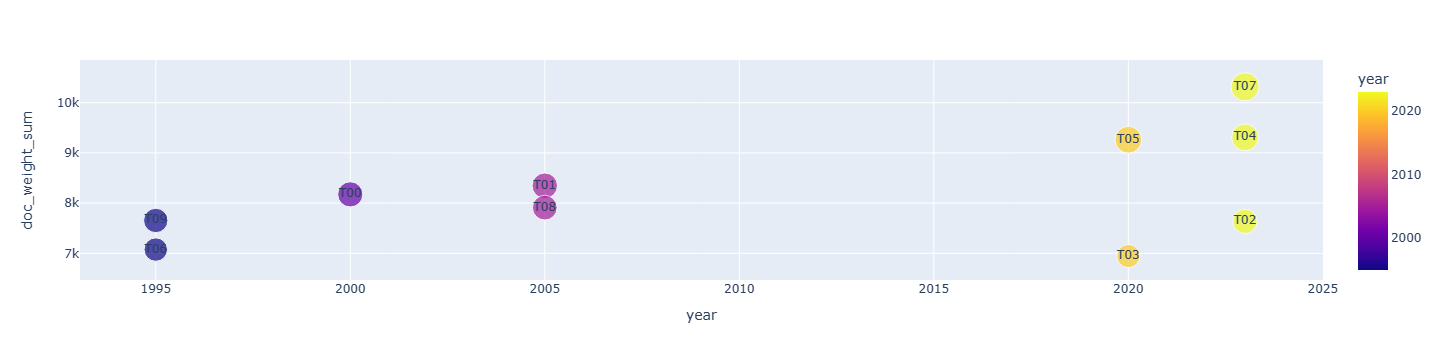

In [23]:
px.scatter(TOPICS.reset_index(), 'year', 'doc_weight_sum',
           hover_name='label', text='topic_id',
           color='year',
           size = (TOPICS.doc_weight_sum),
           width=1000, height=350)

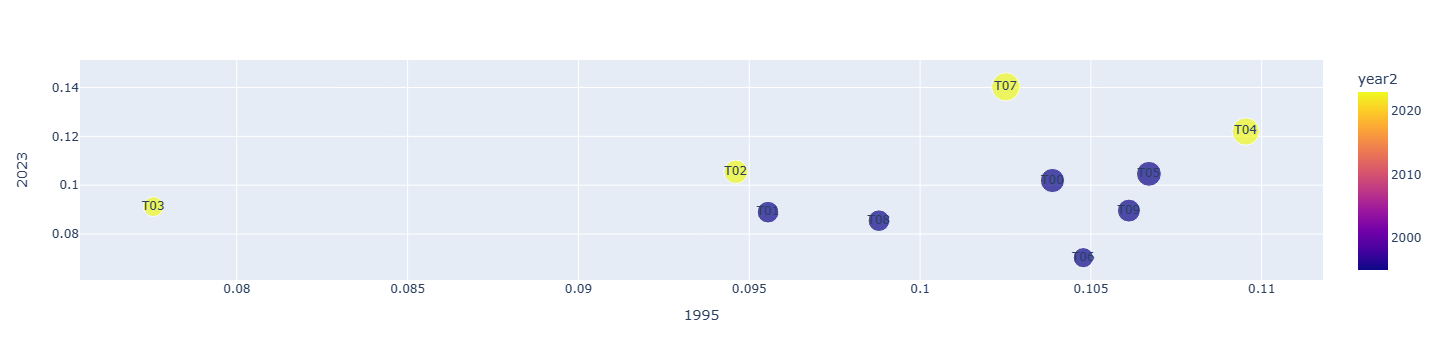

In [71]:
px.scatter(TOPICS.reset_index(), 1995, 2023, 
           hover_name='label', text='topic_id', 
           size=(TOPICS[1995] * TOPICS[2023]),
           color='year2',
           width=1000, height=350)

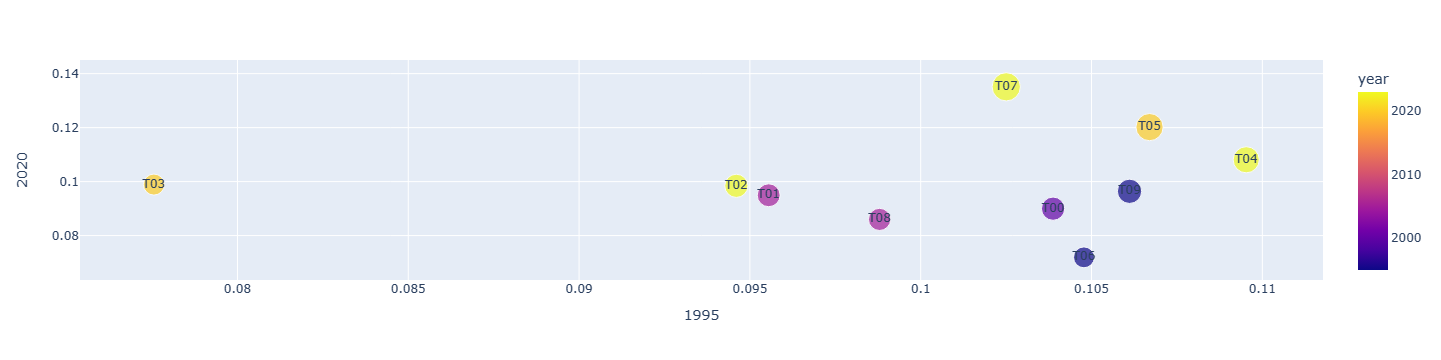

In [25]:
px.scatter(TOPICS.reset_index(), 1995, 2020, 
           hover_name='label', text='topic_id', 
           size=(TOPICS[1995] * TOPICS[2020]),
           color='year',
           width=1000, height=350)

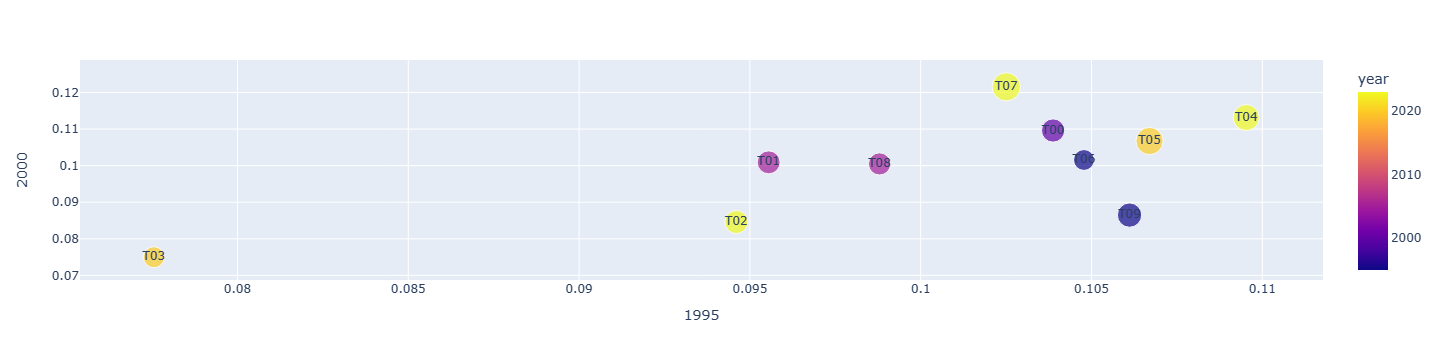

In [26]:
px.scatter(TOPICS.reset_index(), 1995, 2000, 
           hover_name='label', text='topic_id', 
           size=(TOPICS[1995] * TOPICS[2020]),
           color='year',
           width=1000, height=350)

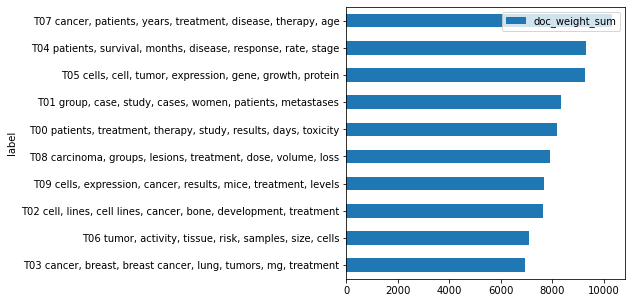

In [27]:
TOPICS.sort_values('doc_weight_sum', ascending=True).plot.barh(y='doc_weight_sum', x='label', figsize=(5, n_topics/2));

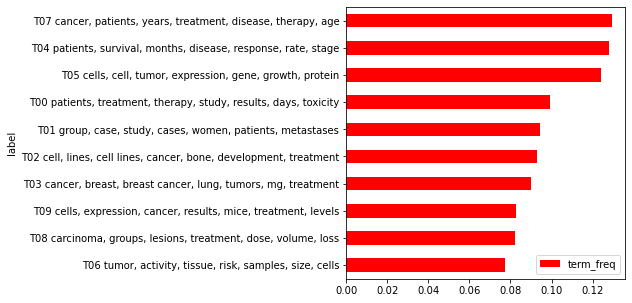

In [28]:
TOPICS.sort_values('term_freq', ascending=True).plot.barh(y='term_freq', x='label', figsize=(5,n_topics/2), color = 'red');